# Work on embeddings

Take Example using Embeddings and attempt to use it to perform cosine similarities. 


In [13]:
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
import numpy as np
import time
print("Available GPUs:", tf.config.list_physical_devices('GPU'))
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = tf.cast(tf.tile(tf.expand_dims(attention_mask, -1), [1, 1, token_embeddings.shape[-1]]), tf.float32)
    return tf.math.reduce_sum(token_embeddings * input_mask_expanded, 1) / tf.math.maximum(tf.math.reduce_sum(input_mask_expanded, 1), 1e-9)


#Encode text
def encode(texts):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='tf')

    # Compute token embeddings
    model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = tf.math.l2_normalize(embeddings, axis=1)

    return embeddings

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1")
model = TFAutoModel.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1")

2023-11-23 22:02:17.462092: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-23 22:02:17.462113: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-23 22:02:17.462118: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-23 22:02:17.462147: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-23 22:02:17.462159: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at sentence-transformers/multi-qa-MiniLM-L6

# Example from Huggingface
https://huggingface.co/sentence-transformers/multi-qa-MiniLM-L6-cos-v1

In [4]:
# Sentences we want sentence embeddings for
query = "How many people live in London?"
docs = ["Around 9 Million people live in London", "London is known for its financial district"]

#Encode query and docs
query_emb = encode(query)
doc_emb = encode(docs)

#Compute dot score between query and all document embeddings
scores = (query_emb @ tf.transpose(doc_emb))[0].numpy().tolist()

#Combine docs & scores
doc_score_pairs = list(zip(docs, scores))

#Sort by decreasing score
doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

#Output passages & scores
for doc, score in doc_score_pairs:
    print(f"Score: {score:.2f}, Query: {doc}.")

Score: 0.92, Query: Around 9 Million people live in London.
Score: 0.49, Query: London is known for its financial district.


# Benchmarks

## Objective: Benchmark Performing Comparisons

Benchmark embeddings comparison for all Show Descriptions

In [10]:
randomquery_raw = "Random Query"
random_query = encode(randomquery_raw)
sizes = [100, 1000, 10000, 100000, 1000000]
for device in ['GPU','CPU']:
    t = []
    for size in sizes:
        start0 = time.time()
        with tf.device(device):
            large_embed = tf.constant(np.random.random((size,384)), dtype=tf.float32)
        end0 = time.time()

        start1 = time.time()
        scores = (random_query @ tf.transpose(large_embed))[0].numpy().tolist()
        end1 = time.time()
        t.append(end1-start1)
        print(f"TF {device}: {end0-start0:.3f}s to create fake data.  {end1-start1:.3f} to perform dot product with {size} rows.")

    print('')

TF GPU: 0.013s to create fake data.  0.006 to perform dot product with 100 rows.
TF GPU: 0.003s to create fake data.  0.003 to perform dot product with 1000 rows.
TF GPU: 0.025s to create fake data.  0.006 to perform dot product with 10000 rows.
TF GPU: 0.248s to create fake data.  0.053 to perform dot product with 100000 rows.
TF GPU: 5.762s to create fake data.  0.556 to perform dot product with 1000000 rows.

TF CPU: 0.002s to create fake data.  0.008 to perform dot product with 100 rows.
TF CPU: 0.002s to create fake data.  0.003 to perform dot product with 1000 rows.
TF CPU: 0.022s to create fake data.  0.012 to perform dot product with 10000 rows.
TF CPU: 0.202s to create fake data.  0.102 to perform dot product with 100000 rows.
TF CPU: 4.363s to create fake data.  1.177 to perform dot product with 1000000 rows.



Text(0, 0.5, 'Seconds to Execute on CPU')

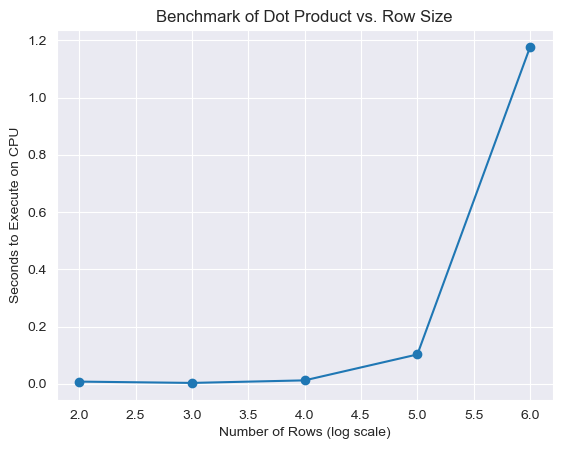

In [18]:
import matplotlib.pyplot as plt
plt.plot(np.log10(sizes),t,'o-')
plt.title('Benchmark of Dot Product vs. Row Size')
plt.xlabel('Number of Rows (log scale)')
plt.ylabel('Seconds to Execute on CPU')